In [138]:
import keras.layers
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow import keras
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import Callback

from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

tf.__version__

'2.10.0'

### 데이터 로드
* TF에서 제공하는 데이터셋을 load해 간단한 전처리 진행

In [139]:
# Load training and eval data from tf.keras
(train_data, train_labels), (test_data, test_labels) = \
    tf.keras.datasets.fashion_mnist.load_data()

In [140]:
print(train_data.shape, train_labels.shape)

(60000, 28, 28) (60000,)


In [141]:
train_data, valid_data, train_labels, valid_labels = \
    train_test_split(train_data, train_labels, test_size=0.1, shuffle=True)

In [142]:
print(train_data.shape, train_labels.shape)

(54000, 28, 28) (54000,)


In [143]:
print(valid_data.shape, valid_labels.shape)

(6000, 28, 28) (6000,)


In [144]:
print(valid_labels[:30])

[6 1 8 9 4 7 9 1 2 2 8 7 4 4 3 4 0 8 7 6 2 0 6 5 5 8 3 6 1 9]


label = 8


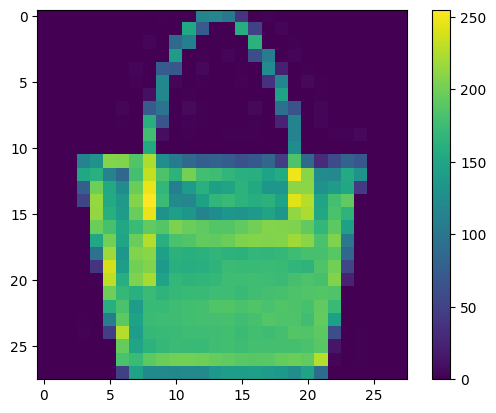

In [145]:
index = 5901
print("label = {}".format(valid_labels[index]))
plt.imshow(valid_data[index].reshape(28, 28))
plt.colorbar()
#plt.gca().grid(False)
plt.show()

In [146]:
train_data = train_data / 255.
train_data = train_data.reshape(-1, 28*28)
train_data = train_data.astype(np.float32)
train_labels = train_labels.astype(np.int32)

test_data = test_data / 255.
test_data = test_data.reshape(-1, 28*28)
test_data = test_data.astype(np.float32)
test_labels = test_labels.astype(np.int32)

valid_data = valid_data / 255.
valid_data = valid_data.reshape(-1, 28*28)
valid_data = valid_data.astype(np.float32)
valid_labels = valid_labels.astype(np.int32)


print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)
print(valid_data.shape, valid_labels.shape)


(54000, 784) (54000,)
(10000, 784) (10000,)
(6000, 784) (6000,)


### 학습에 사용할 tf.data.Dataset 구성
* 학습에 잘 적용할 수 있도록 label 처리
* 데이터셋 구성

In [147]:
def one_hot_label(image, label):
  label = tf.one_hot(label, depth=10)
  return image, label

In [148]:
batch_size = 32

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_data,train_labels)) # tuple로 묶어서 넣어줘야 함
train_dataset = train_dataset.shuffle(buffer_size=10000)
train_dataset = train_dataset.map(one_hot_label) # 함수호출이 아닌 함수명만 적음
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_data,test_labels))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

# for test
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_data,valid_labels))
valid_dataset = valid_dataset.map(one_hot_label)
valid_dataset = valid_dataset.batch(batch_size=batch_size)
print(valid_dataset)

<BatchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


### 모델 구성

In [149]:
# Dense 64 relu
# Dense 32 relu
# Output Layer
# 28 * 28
model = tf.keras.Sequential([
    layers.Dense(64, kernel_initializer=tf.keras.initializers.HeUniform()),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    # 학습시작이 잘 안될때, kernel_initializer=tf.keras.initializers.HeUniform() 추가 러닝레이트 조절 
    # 학습시작에대한 관여. 초기값을 잘 주는게 중요
    
    layers.Dense(32, kernel_initializer=tf.keras.initializers.HeUniform()),
    layers.BatchNormalization(),
    
    # 학습이 좀 빨라짐 적은에폭에 빨리올라감
    layers.Activation('relu'),

    layers.Dense(10, kernel_initializer=tf.keras.initializers.HeUniform()),
    layers.BatchNormalization(),
    layers.Activation('softmax'),

]
)

In [150]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [151]:
# without training, just inference a model in eager execution:
predictions = model(train_data[0:1], training=False)
print("Predictions: ", predictions.numpy())

Predictions:  [[0.08232321 0.03321914 0.14035392 0.07189199 0.16308543 0.15014347
  0.08217472 0.07943527 0.05385271 0.1435202 ]]


In [152]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_37 (Dense)            (1, 64)                   50240     
                                                                 
 batch_normalization (BatchN  (1, 64)                  256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (1, 64)                   0         
                                                                 
 dense_38 (Dense)            (1, 32)                   2080      
                                                                 
 batch_normalization_1 (Batc  (1, 32)                  128       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (1, 32)                  

### 모델 학습 구성

In [153]:
check_point_cb = callbacks.ModelCheckpoint('fashion_mnist_model.h5',
                                           save_best_only=True,
                                           verbose=1)
early_stopping_cb = callbacks.EarlyStopping(patience=10,
                                            monitor='val_loss',
                                            restore_best_weights=True,
                                            verbose=1)

In [154]:
# max_epochs = 100
# # using `tf.data.Dataset`
# history = model.fit(train_dataset, epochs=max_epochs,
#                     steps_per_epoch=len(train_data) // batch_size,
#                     validation_data=valid_dataset,
#                     validation_steps=len(valid_data) // batch_size,
#                     callbacks=[check_point_cb, early_stopping_cb]
#                    )
max_epochs = 100
# using `tf.data.Dataset`
history = model.fit(train_dataset,
                    epochs=max_epochs,
                    steps_per_epoch=len(train_data) // batch_size,
                    validation_data=valid_dataset,
                    validation_steps=len(valid_data) // batch_size,
                    callbacks=[check_point_cb, early_stopping_cb]
                    )

Epoch 1/100


2023-12-26 12:36:31.894198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1686/1687 [============================>.] - ETA: 0s - loss: 1.0381 - accuracy: 0.7222

2023-12-26 12:37:03.964306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.72676, saving model to fashion_mnist_model.h5
1687/1687 [==============================] - 34s 20ms/step - loss: 1.0380 - accuracy: 0.7222 - val_loss: 0.7268 - val_accuracy: 0.8100
Epoch 2/100
1686/1687 [============================>.] - ETA: 0s - loss: 0.7468 - accuracy: 0.8085
Epoch 2: val_loss improved from 0.72676 to 0.59554, saving model to fashion_mnist_model.h5
1687/1687 [==============================] - 33s 19ms/step - loss: 0.7468 - accuracy: 0.8085 - val_loss: 0.5955 - val_accuracy: 0.8362
Epoch 3/100
1686/1687 [============================>.] - ETA: 0s - loss: 0.6538 - accuracy: 0.8266
Epoch 3: val_loss improved from 0.59554 to 0.54316, saving model to fashion_mnist_model.h5
1687/1687 [==============================] - 33s 20ms/step - loss: 0.6538 - accuracy: 0.8266 - val_loss: 0.5432 - val_accuracy: 0.8488
Epoch 4/100
1685/1687 [============================>.] - ETA: 0s - loss: 0.6013 - accuracy: 0.8352
Epoch 4: val_loss improved f

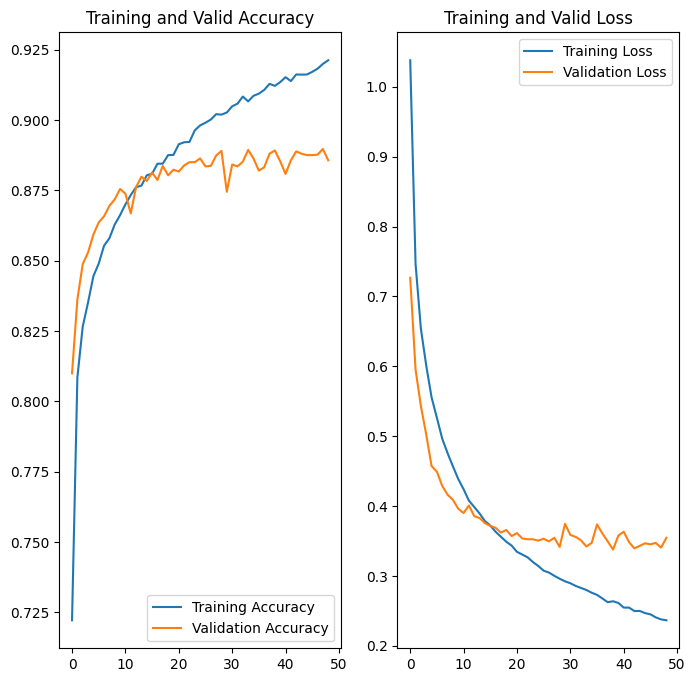

In [155]:
# 코드 수정
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Valid Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Valid Loss')
plt.show()

In [156]:
results = model.evaluate(test_dataset)

313/313 [==============================] - 4s 11ms/step - loss: 0.3481 - accuracy: 0.8831
